* Autor do notebook: [Bruno Silva](https://github.com/bgsilva)
* Notebook baseado no material do curso ['Fraud Detection in Python'](https://app.datacamp.com/learn/courses/fraud-detection-in-python) da platafotma [Datacamp](https://www.datacamp.com/) 



# Detecção de fraudes em cartões de crédito

**Contexto**

Fraudes em transações com cartões de crédito representam anualmente uma perda de receita considerável para as empresas de cartão de crédito. Logo, é importante que essas empresas sejam capazes de reconhecer tais tipos de transações, evitando que clientes sejam cobrados indevidamente.

Usando algoritmos de machine learning supervisionado, podemos detectar comportamento fraudulento com base em fraudes anteriores. Já com algoritmos de machine learning não supervisionado, podemos descobrir novos tipos de atividades de fraude.

De maneira geral, as transações fraudulentas são raras em comparação com o total de transações efetuadas, resultando em dados desbalanceados.


**Conteúdo do conjunto de dados**  

O conjunto de dados (dataset) contém transações feitas por cartões de crédito em setembro de 2013 por titulares de cartões europeus.

Este conjunto de dados apresenta transações que ocorreram em dois dias, onde há 492 fraudes em 284.807 transações. O conjunto de dados é altamente desbalanceado, a classe positiva (fraudes) é responsável por 0,172% de todas as transações.

O dataset contém apenas variáveis de entrada numéricas que são o resultado de uma transformação PCA. Infelizmente, devido a questões de confidencialidade, as features originais e outras informações básicas sobre os dados não são fornecidas. As features V1, V2, ..., V28 são as principais componentes obtidas com a PCA, as únicas features que não foram transformadas com a transformação PCA são 'Time' e 'Amount'. A feature 'Time' contém os segundos decorridos entre cada transação e a primeira transação no dataset. A feature 'Amount' é o valor da transação, esta feature pode ser usado como exemplo de aprendizagem dependente de custos. A feature 'Class' é a variável de resposta e assume o valor 1 em caso de fraude e 0 no caso contrário.

É importante lembrar que a acurácia da matriz de confusão não é significativa para a classificação não balanceada, sendo recomendada a medida da acurácia usando a área sob a curva precisão-recall - Area Under the Precision-Recall Curve (AUPRC).

Fonte do dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

---


# Introdução e preparação dos dados

Neste parte inicial, iremos ter o primeiro contato com o dataset e conhecer alguns modos de reamostrar os dados para lidar com problema de desbalanceamento dos dados originais.


Bibliotecas utilizadas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Funções utilizadas

In [2]:
# Função utilizada para criação de um gráfico de dispersão dos dados (rotulados)
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()
 
# Função utilizada para separar as colunas das features da coluna com os rótulos de fraude
def prep_data(df):
    X = df.iloc[:, 1:29]
    X = np.array(X).astype(float)
    y = df.iloc[:, 30]
    y = np.array(y).astype(float)
    return X,y

# Função utilizada criar um plot p/ comparar os dados reamostrados com os dados originais
def compare_plot(X, y, X_resampled, y_resampled, method):
    # Iniciar o plot
    f, (ax1, ax2) = plt.subplots(1, 2)
    # sub-plot número 1, dados normais
    c0 = ax1.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0",alpha=0.5)
    c1 = ax1.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1",alpha=0.5, c='r')
    ax1.set_title('Original set')
    # sub-plot número 2, dados sobreamostrados
    ax2.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=.5)
    ax2.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=.5,c='r')
    ax2.set_title(method)
    # ajustes na figura
    plt.figlegend((c0, c1), ('Class #0', 'Class #1'), loc='lower center',
                ncol=2, labelspacing=0.)
    #plt.tight_layout(pad=3)
    return plt.show()

# Função utilizada criar um plot com a curva precisão-recall
def plot_pr_curve(recall, precision, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

# Função utilizada para treinar o modelo
def get_model_results(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)
    print (classification_report(y_test, predicted))
    print (confusion_matrix(y_test, predicted))

Carregando e visualizando o dataset

In [3]:
df = pd.read_csv("creditcard.csv")

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Explorando as features disponíveis no dataframe 

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Contando as ocorrências de 'fraude' e 'não fraude'

In [6]:
occ = df['Class'].value_counts()
print(occ)

0    284315
1       492
Name: Class, dtype: int64


Imprimindo a proporção de casos de fraude

In [7]:
print(occ / len(df.index))

0    0.998273
1    0.001727
Name: Class, dtype: float64


Criando X e y a partir da função 'prep_data'

In [8]:
X, y = prep_data(df)

Plotando os dados executando a função 'plot_data' em X e y

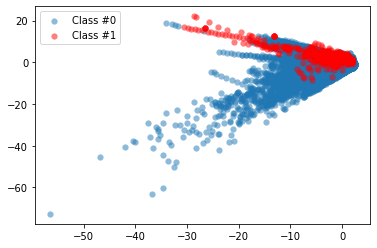

In [9]:
plot_data(X, y)

A partir da visualização dos dados, podemos notar de maneira claramento como os casos de fraudes estão espalhados (Class #1) e como possuímos poucos deles em relação ao número total de casos. 

## Aplicando a técnica de rebalanceamento SMOTE

Iremos rebalencear os dados usando a técnica de sobreamostragem SMOTE (Synthetic Minority Over-sampling Technique). A técnica SMOTE não cria cópias exatas das observações, mas cria novas amostras sintéticas que são bastante semelhantes às observações existentes na classe minoritária. A técnica SMOTE é, portanto, um pouco mais sofisticada do que apenas copiar observações.

Iremos visualizar o resultado e compará-lo com os dados originais, de modo que possamos observar o efeito da aplicação da técnica SMOTE de forma clara.

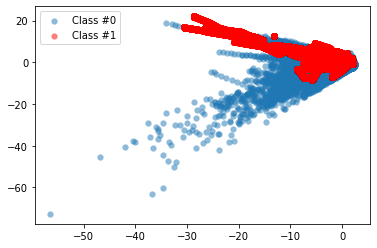

In [10]:
from imblearn.over_sampling import SMOTE

# Rodando a função 'prep_data' function'
X, y = prep_data(df)

# Definindo o método de resampling
method = SMOTE(k_neighbors=2)

# Criando um conjuntos de features reamostradas
X_resampled, y_resampled = method.fit_resample(X, y)

# Plotando os dados reamostrados
plot_data(X_resampled, y_resampled)

### Comparando os resultados

Vimos que usar SMOTE nos dá mais observações da classe minoritária. Vamos comparar esses resultados com nossos dados originais, para ter uma boa ideia do que realmente aconteceu. Vamos dar uma olhada nas contagens dos valores de nossos dados antigos e novos e plotar os dois gráficos de dispersão dos dados lado a lado.

Usaremos a função 'compare_plot()' para isso, que leva os seguintes argumentos: X, y, X_resampled, y_resampled, method = ''. A função plota os dados originais em um gráfico de dispersão, junto com os reamostrados lado a lado.


0.0    284315
1.0       492
dtype: int64
0.0    284315
1.0    284315
dtype: int64


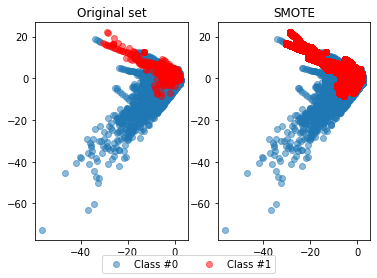

In [11]:
# Imprimindo value_counts dos dados originais y
print(pd.value_counts(pd.Series(y)))

# mprimindo value_counts dos dados reamostrados y
print(pd.value_counts(pd.Series(y_resampled)))

# Rodar 'compare_plot'
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

Deve estar claro a  esta altura que SMOTE equilibrou os dados completamente e que a classe minoritária agora é igual em tamanho à classe majoritária. A visualização dos dados mostra o efeito em seus dados de forma muito clara.

## Explorando a maneira tradicional de detectar fraudes

Iremos agora tentar encontrar casos de fraude no dataset de cartão de crédito da maneira tradicional. 

Primeiro, definiremos os valores de limite usando estatísticas comuns, para separar 'fraude' e 'não fraude'. 

Em seguida, usaremos esses limites nas features para detectar fraude. Esta é uma prática comum em equipes de análise de fraude.

In [12]:
# Obtendo a média para cada grupo
df.groupby('Class').mean()

# Implementando uma regra para indicar quais casos são sinalizados como fraude
# Criando a condição V1 menor que -3 e V3 menor que -5 como condição para sinalizar casos de fraude.
df['flag_as_fraud'] = np.where(np.logical_and(df['V1']<-3, df['V3']<-5), 1, 0)

# Criando uma tabela cruzada (crosstab) de casos de fraude sinalizados versus casos de fraude reais
# Como medida de desempenho, usaremos a função 'crosstab' do pandas para comparar os casos de fraude sinalizados com casos reais de fraude.
print(pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud       0     1
Actual Fraud               
0              283089  1226
1                 322   170


Com essa regra, detectamos 170 de 492 casos de fraude, mas não conseguimos detectar os outros 322 e obtemos 1226 falsos positivos. Veremos a seguir como isso se compara a um modelo de machine learning.

## Usando a classificação por ML para detectar fraudes

Veremos o que acontece ao usar um modelo simples de ML nos dados de cartão de crédito.

Vamos implementar um modelo de regressão logística.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X, y = prep_data(df)

# Criando os conjuntos de treinamento e teste / test size: 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)

# Fitando o modelo de regressão logística aos dados
model = LogisticRegression()
model.fit(X_train, y_train)

# Obtendo as previsões do modelo
predicted = model.predict(X_test)

# Imprimnido o relatório de classificação (classification_report) e matriz de confusão (confusion_matrix)
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.89      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.95      0.81      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Confusion matrix:
 [[85285    11]
 [   56    91]]


Agora conseguimos detectar 91 de 147 casos de fraude, mas não conseguimos detectar os outros 56 e obtemos 11 falsos positivos.

### Regressão logística combinada com SMOTE

Vamos pegar o modelo de regressão logística do exemplo anterior e combiná-lo com um método de reamostragem SMOTE. Veremos como fazer isso de forma eficiente usando um pipeline que combina o método de reamostragem com o modelo de uma vez.

Primeiro, precisamos definir o pipeline que vai usar.

In [12]:
# Módulo de pipeline da biblioteca imblearn de que precisamos
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

# Definir qual método de reamostragem e qual modelo de ML usar no pipeline
resampling = SMOTE()
model = LogisticRegression()

# Definindo o pipeline: diga a ele para combinar SMOTE com o modelo de regressão logística
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

### Usando um pipeline

Agora que definimos o pipeline, vamos executá-lo nos dados. Podemos tratar o pipeline como se fosse um único modelo de aprendizado de máquina.

In [13]:
# # Criando os conjuntos de treinamento e teste / test size: 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitando o modelo de regressão logística ao conjunto de treino obter previsões Fitando o modelo ao conjunto de teste 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Imprimnido o relatório de classificação (classification_report) e matriz de confusão (confusion_matrix)
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     85296
         1.0       0.06      0.92      0.11       147

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443

Confusion matrix:
 [[83191  2105]
 [   12   135]]


Resumindo o resultado:
* Proporção de casos que o modelo acerta como fraude em relação ao que modelo prediz como fraude (precision): 135/(135+2103) ~ 0.06 --> muitos casos de não fraude são preditos como fraude (precição baixa).
* Proporção de casos que o modelo acerta como fraude em relação ao total de fraudes (recall): 135/(135+12) ~ 0.92 --> prediz a maioria das fraudes corretamente (recall alto).

---


Como podemos ver, o SMOTE melhora ligeiramente nossos resultados. Conseguimos agora localizar todos os casos de fraude, mas temos um número ligeiramente superior de falsos positivos, embora sejam apenas 2108 casos.

Lembre-se de que nem em todos os casos a reamostragem leva necessariamente a melhores resultados. Quando os casos de fraude estão muito espalhados e dispersos pelos dados, o uso do SMOTE pode introduzir um pouco de bias. Vizinhos mais próximos não são necessariamente também casos de fraude, então as amostras sintéticas podem 'confundir' um pouco o modelo.

A seguir aprenderemos como ajustar nossos modelos de NL para detectar melhor os casos de fraude minoritária.



# Detecção de fraude usando dados rotulados

Agora estamos familiarizado com os principais desafios da detecção de fraude, vamos aprender como sinalizar transações fraudulentas com aprendizado supervisionado.

Usaremos alguns classificadores e vamos ajustá-los e compará-los para encontrar o modelo de detecção de fraude mais eficiente.

Primeiro, precisamos explorar o quão prevalente é a fraude no conjunto de dados, para entender qual é a 'acurácia natural', se fossemos prever tudo como não fraude.

É importante entender qual nível de acurácia precisamos "vencer" para obter uma previsão melhor do que não fazer nada.

Iremos criar primeiro um classificador Random Forest para detecção de fraude. Ele servirá como o modelo baseline que tentaremos melhorar mais adiante.

In [18]:
# Contando o número total de observações a partir tamanho de y
total_obs = len(y)

# Contando o número total de observações não fraudulentas
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculando a porcentagem de observações não fraudulentas no conjunto de dados
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Imprimir a porcentagem: esta é a nossa 'acurácia natural' sem fazer nada
print(percentage)

99.82725143693798


Isso nos diz que, ao não fazer nada, estaríamos corretos em 99,83% dos casos. 

Portanto, se obtivermos uma acurácia menor do que esse número, nosso modelo não adicionará nenhum valor na previsão de quantos casos estão corretos.

Agora veremos como um classificador Random Forest se sai na previsão de fraudes em nossos dados.



## Classificador Random Forest

Vamos agora criar um primeiro classificador Random Forest para detecção de fraude.
Esperamos poder fazer melhor do que a acurácia do modelo baseline que acabamos de calcular, que foi de aproximadamente 99,83%.

Este modelo servirá como o modelo baseline que tentaremos melhorar mais adiante. 

Vamos começar dividindo os dados em um conjunto de teste e treinamento e definindo o modelo Random Forest.

In [15]:
# Importando o modelo random forest da biblioteca sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Criando os conjuntos de treinamento e teste / test size: 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Definindo o modelo como random forest
model = RandomForestClassifier(random_state=5)

# Fitando o modelo ao conjunto de treino
model.fit(X_train, y_train)

# Obtendo previsões a partir do conjunto de teste
predicted = model.predict(X_test)

# Imprima a métrica de desempenho de acurácia
print(accuracy_score(y_test, predicted))

0.9995201479348805


O Random Forest evita overfitting na maioria das vezes, criando subconjuntos aleatórios das features e construindo árvores menores usando esses subconjuntos.
Posteriormente, ele combina as subárvores de subamostras de features, de modo que não tende a se ajustar a todo o conjunto de features da mesma forma que as árvores de decisão 'profundas' fazem.

### Métricas de desempenho para o modelo RF

Anteriormente, obtemos uma pontuação da acurácia para o modelo baseline Random Forest.

Desta vez, sabemos que a acurácia pode ser enganosa no caso de detecção de fraude.

Além disso, o relatório de classificação (classification report) informa sobre a precisão e o recall do modelo, enquanto a matriz de confusão mostra quantos casos de fraude você pode prever corretamente. Então, vamos obter essas métricas de desempenho.



In [16]:
# Importando os pacotes para obter as diferentes métricas de desempenho
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtendo as previsões de nosso modelo random forest
predicted = model.predict(X_test)

# Prever probabilidades
probs = model.predict_proba(X_test)

# Imprimindo a curva ROC, relatório de classificação e matriz de confusão
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9440157253109459
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.95      0.76      0.85       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

[[85290     6]
 [   35   112]]


Agora obtemos métricas de desempenho mais significativas que nos informam sobre o desempenho do modelo, considerando os dados altamente desbalanceados com os quais estamos trabalhando.

O modelo prevê 118 casos de fraude, dos quais 112 são fraudes reais. Temos apenas 6 falsos positivos.

Isso é muito bom e, como resultado, temos uma pontuação de precisão muito alta. No entanto, não detectamos 35 casos de fraude real.
Portanto, o recall não é tão boa quanto a precisão.

### Plotando a curva Precision-Recall

Também podemos plotar uma curva Precision-Recall, para investigar a compensação entre precisão e recall no modelo.

Nesta curva, a precisão e o recall estão inversamente relacionados; à medida que a precisão aumenta, o recall diminui e vice-versa.

Um equilíbrio entre esses dois precisa ser alcançado no modelo, caso contrário, podemos acabar com muitos falsos positivos ou não detectar casos reais de fraude suficientes.

Para conseguir isso e comparar o desempenho, as curvas de Precision-Recall são úteis.








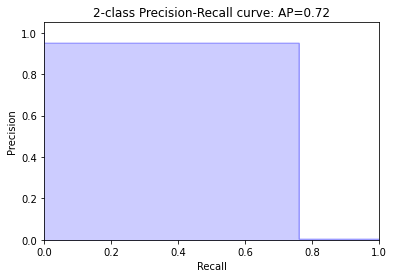

In [17]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

# Calculando a precisão média e a curva PR
average_precision = average_precision_score(y_test, predicted)

# Obtendo precisão e recall
precision, recall, _ = precision_recall_curve(y_test, predicted)

# Plotando o tradeoff recall precision 
plot_pr_curve(recall, precision, average_precision)

A curva ROC representa os verdadeiros positivos vs. falsos positivos, para um classificador, a medida que seu limite de limiar é variado.

Visto que um método aleatório descreve uma curva horizontal através do intervalo de unidades, ele tem uma AUC ('área sob a curva') de 0,5.

No mínimo, os classificadores devem ter um desempenho melhor do que isso e, na medida em que pontuam mais alto que um do outro (o que significa que a área sob a curva ROC é maior), eles têm melhor desempenho esperado.

### Ajustes do modelo

Uma maneira simples de ajustar o modelo random forest para lidar com dados de fraude altamente desbalanceados é usar a opção `class_weights` ao definir o modelo.

No entanto, como veremos, é um mecanismo de força um pouco cego e pode não funcionar para o algum caso muito especial.

Aqui, vamos explorar o modo `class_weight = balance_subsample` do modelo Random Forest do exercício anterior.


In [18]:
from sklearn.metrics import roc_auc_score

# Definindo o modelo com subamostra balanceada
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fitando o modelo ao conjunto de treino
model.fit(X_train, y_train)

# Obtendo os valores preditos e as probabilidades do modelo
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Imprimindo o roc_auc_score, o relatório de classificação e a matriz de confusão
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9375045061168342
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.97      0.74      0.84       147

    accuracy                           1.00     85443
   macro avg       0.99      0.87      0.92     85443
weighted avg       1.00      1.00      1.00     85443

[[85293     3]
 [   38   109]]


Podemos ver que os resultados do modelo não melhoraram drasticamente.

Agora temos 2 falsos positivos a menos, mas temos 36 em vez de 35 falsos negativos, ou seja, casos de fraude que não estamos detectando.

Se nos preocupamos principalmente com a detecção de fraudes, e não tanto com os falsos positivos, isso na verdade não melhora nosso modelo em nada, embora seja uma opção simples de tentar.

Nos próximos exercícios, veremos como ajustar o modelo de maneira mais inteligente para se concentrar na redução de falsos negativos e detectar mais fraudes.

### Ajustando a Random Forest para detecção de fraude

Focaremos nas opções para o classificador random forest, pois iremos atribuir pesos e ajustar a forma das árvores de decisão na floresta.

Definiremos os pesos manualmente, para poder compensar um pouco esse desbalanceamento.

No nosso caso, temos 147 casos de fraude para 85296 não-fraude, então, definindo a proporção de peso em 1:600.

Podemos então usar a função `get_model_results()` como um atalho.

Esta função ajusta o modelo aos seus dados de treinamento, prevê e obtém métricas de desempenho semelhantes às etapas executadas nos exercícios anteriores.

In [19]:
# Alterando as opções do modelo
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:600}, criterion='entropy',

            # Mudando a profundidade do modelo
            max_depth=10,

            # Alterando o número de amostras nos nós da folha
            min_samples_leaf=10, 

            # Alterando o número de árvores a usar
            n_estimators=20, n_jobs=-1, random_state=5)

# Executando a função get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.84      0.82      0.83       147

    accuracy                           1.00     85443
   macro avg       0.92      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443

[[85273    23]
 [   27   120]]


Podemos ver que, definindo de forma inteligente mais opções no modelo, podemos obter melhores previsões.

Reduzimos efetivamente o número de falsos negativos, ou seja, estamos detectando mais casos de fraude, enquanto mantemos baixo o número de falsos positivos.

Neste exercício, alteramos manualmente as opções do modelo. Porém, existe uma maneira mais inteligente de fazer isso, usando `GridSearchCV`, que veremos a seguir.

### Usando GridSearchCV para encontrar os parâmetros ideais

Vamos ajustar o modelo de uma forma menos 'aleatória', mas usaremos o GridSearchCV para fazer o trabalho para nós.

Com GridSearchCV podemos definir em qual métrica de desempenho pontuar as opções.

Como, para a detecção de fraudes, estamos mais interessados em detectar o maior número possível de casos de fraude, podemos otimizar as configurações do modelo para obter a melhor pontuação de recall possível.

Se você também se preocupar em reduzir o número de falsos positivos, poderia otimizar o F1-score, o que dá uma boa compensação no Precision-Recall.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Definindo os conjuntos de parâmetros para testar
param_grid = {'n_estimators': [1, 32], 'max_features': ['auto', 'log2'],  'max_depth': [1, 10], 'criterion': ['gini', 'entropy']
}

# Definindo o modelo a ser usado
model = RandomForestClassifier(random_state=5)

# Combinando os conjuntos de parâmetros com o modelo definido
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Ajustar o modelo aos nossos dados de treinamento e obter os melhores parâmetros
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 32}

### Resultados do modelo usando GridSearchCV

Descobrimos que os melhores parâmetros para o modelo são que o critério de divisão deve ser definido como 'entropy', o número de estimadores (árvores) deve ser 30, a profundidade máxima do modelo deve ser 8 e os recursos máximos devem ser definidos como 'auto'.

Vamos verificar como o modelo vai performar. Podemos usar a função get_model_results novamente para economizar tempo.

In [27]:
# Inserindo os parâmetros ideais no modelo
model = RandomForestClassifier(class_weight={0:1,1:600}, criterion='entropy',
            max_depth=8, max_features='auto',  min_samples_leaf=10, n_estimators=10, n_jobs=-1, random_state=5)

# Obtendo os resultados de seu modelo
get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.75      0.84      0.79       147

    accuracy                           1.00     85443
   macro avg       0.87      0.92      0.89     85443
weighted avg       1.00      1.00      1.00     85443

[[85254    42]
 [   24   123]]


Conseguimos melhorar ainda mais o modelo.

O número de falsos negativos foi reduzido ainda mais, o que significa que estamos detectando mais casos de fraude.

No entanto, vemos que o número de falsos positivos realmente aumentou. Essa é a compensação Precision-Recall em ação.

Para decidir qual modelo final é o melhor, precisamos levar em consideração o quão ruim é não pegar os fraudadores, em comparação com quantos falsos positivos a equipe de análise de fraude pode lidar.

Em última análise, essa decisão final deve ser tomada por você e a equipe de fraude juntos.

## Métodos Ensemble


### Regressão Logística

Combinaremos três algoritmos em um modelo com o VotingClassifier.

Isso nos permite tirar proveito dos diferentes aspectos de todos os modelos e, com sorte, melhorar o desempenho geral e detectar mais fraudes.

O primeiro modelo, a regressão logística, tem uma pontuação de recall ligeiramente maior do que nosso modelo de Random Forest otimizado, mas dá muito mais falsos positivos.

Iremos adicionar também uma árvore de decisão com pesos balanceados.

Para entender como o Voting Classifier pode potencialmente melhorar o modelo original, devemos verificar os resultados autônomos do modelo de Regressão Logística primeiro.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X, y = prep_data(df)

# Criando os conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn import preprocessing
from sklearn import utils

lab_enc = preprocessing.LabelEncoder()
y_train = lab_enc.fit_transform(y_train)

# Ajustando um modelo de regressão logística aos nossos dados
model = LogisticRegression(class_weight={0:1, 1:600}, random_state=5)

get_model_results(X_train, y_train, X_test, y_test, model)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     85296
         1.0       0.06      0.91      0.12       147

    accuracy                           0.98     85443
   macro avg       0.53      0.94      0.55     85443
weighted avg       1.00      0.98      0.99     85443

[[83300  1996]
 [   13   134]]


Como podemos ver, a regressão logística tem um desempenho bastante diferente do random forest.

Mais falsos positivos, mas também um recall melhor.

Será, portanto, uma adição útil ao random forest em um modelo ensemble.

### Voting Classifier

Agora, vamos combinar três modelos de ML em um, para melhorar nosso modelo anterior de detecção de fraudes random forest.

Combinaremos nosso modelo usual de random forest, com a regressão logística do exercício anterior, com uma árvore de decisão simples.

Podemos usar o atalho get_model_results para ver o resultado imediato do modelo ensemble.

In [30]:
# Importando as bibliotecas
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Definindo os três classificadores a serem usados ​​no conjunto
clf1 = LogisticRegression(class_weight={0:1, 1:600}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:600}, criterion='entropy', max_depth=8, max_features='auto',
            min_samples_leaf=10, n_estimators=10, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combinando os classificadores no modelo ensemble
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='soft')

# Obtendo os resultados
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.71      0.83      0.76       147

    accuracy                           1.00     85443
   macro avg       0.85      0.91      0.88     85443
weighted avg       1.00      1.00      1.00     85443

[[85246    50]
 [   25   122]]


Diminuímos os casos de fraude que detectados com apenas alguns falsos positivos extras em troca.
 
Se você se preocupa em detectar o máximo de casos de fraude que puder, enquanto mantém os falsos positivos baixos, esta é uma boa troca.

A regressão logística como um autônomo foi muito ruim em termos de falsos positivos, e o  Random Forest foi pior em termos de falsos negativos.

Ao combiná-los, realmente conseguimos melhorar o desempenho.

### Ajustando os pesos no Voting Classifier

Acabamos de ver que o Voting Classifier permite que melhoremos o desempenho na detecção de fraudes, combinando aspectos positivos de vários modelos.

Agora, vamos tentar ajustar os pesos que damos a esses modelos.

Aumentando ou diminuindo os pesos, podemos brincar com quanta ênfase daremos a um modelo específico em relação ao resto.

Isso é útil quando um determinado modelo tem desempenho geral melhor do que o resto, mas ainda desejamos combinar aspectos dos outros para melhorar ainda mais seus resultados.

In [31]:
# Definindo o modelo ensemble
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Obtendo os resultados
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85296
         1.0       0.73      0.84      0.78       147

    accuracy                           1.00     85443
   macro avg       0.87      0.92      0.89     85443
weighted avg       1.00      1.00      1.00     85443

[[85251    45]
 [   23   124]]


A opção de peso permite que você jogue com os modelos individuais para obter a melhor combinação final para o modelo de detecção de fraude.

# Links

[Transaction data simulator](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html)

Dados obtidos de [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

Curso de detecção de fraude [Datacamp](https://campus.datacamp.com/courses/fraud-detection-in-python/)